In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import itertools
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import pickle
import torch, torch.nn as nn, torch.optim as optim, gc, contextlib
from torch.utils.data import TensorDataset, DataLoader

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)  # fix random numbers

In [3]:
torch.cuda.is_available()

True

In [4]:
 # try to set device to GPU if CUDA is available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
torch.set_default_device(device)
torch.get_default_device()

device(type='cuda', index=0)

# Read and preprocess data

In [8]:
data = pd.read_csv('../data/single-yield_training_data.csv')

## Basic statistics

In [9]:
data.head(8)

,$A_{00}$,$A_{01}$,$A_{10}$,$A_{11}$,$P_{00}$,$P_{01}$,$P_{10}$,$P_{11}$
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0
1,6.729700e+07,1.979706e+05,1.979706e+05,1.562848e+08,-0.0,0.0,0.0,0.0
2,1.345940e+08,7.918822e+05,7.918822e+05,3.125695e+08,-0.0,0.0,0.0,0.0
3,2.018910e+08,1.781735e+06,1.781735e+06,4.688543e+08,-0.0,0.0,0.0,0.0
4,2.691880e+08,3.167529e+06,3.167529e+06,6.251390e+08,-0.0,0.0,0.0,0.0
5,3.364850e+08,4.949264e+06,4.949264e+06,7.814238e+08,-0.0,0.0,0.0,0.0
6,4.037820e+08,7.126940e+06,7.126940e+06,9.377086e+08,-0.0,0.0,0.0,0.0
7,4.710790e+08,9.700557e+06,9.700557e+06,1.093993e+09,-0.0,0.0,0.0,0.0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405000 entries, 0 to 404999
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   $A_{00}$  405000 non-null  float64
 1   $A_{01}$  405000 non-null  float64
 2   $A_{10}$  405000 non-null  float64
 3   $A_{11}$  405000 non-null  float64
 4   $P_{00}$  405000 non-null  float64
 5   $P_{01}$  405000 non-null  float64
 6   $P_{10}$  405000 non-null  float64
 7   $P_{11}$  405000 non-null  float64
dtypes: float64(8)
memory usage: 24.7 MB


In [11]:
display(data.shape)

(405000, 8)

In [12]:
data.describe()

,$A_{00}$,$A_{01}$,$A_{10}$,$A_{11}$,$P_{00}$,$P_{01}$,$P_{10}$,$P_{11}$
count,4.050000e+05,4.050000e+05,4.050000e+05,4.050000e+05,405000.000000,405000.000000,405000.000000,405000.000000
mean,1.707500e+11,6.336300e+10,6.336300e+10,1.307500e+11,0.083365,0.257930,0.257930,-0.083365
std,1.362263e+11,4.810844e+10,4.810844e+10,8.570968e+10,0.143911,0.276212,0.276212,0.143911
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.207125,0.000000,0.000000,-0.651942
25%,6.003946e+10,2.091836e+10,2.091836e+10,6.032002e+10,0.000000,0.000000,0.000000,-0.144948
50%,1.349900e+11,5.021009e+10,5.021009e+10,1.207683e+11,0.013435,0.158579,0.158579,-0.013435
75%,2.544760e+11,1.001582e+11,1.001582e+11,1.887175e+11,0.144948,0.463328,0.463328,0.000000
max,6.225000e+11,1.800000e+11,1.800000e+11,3.825000e+11,0.651942,0.977913,0.977913,0.207125


## Visualize data

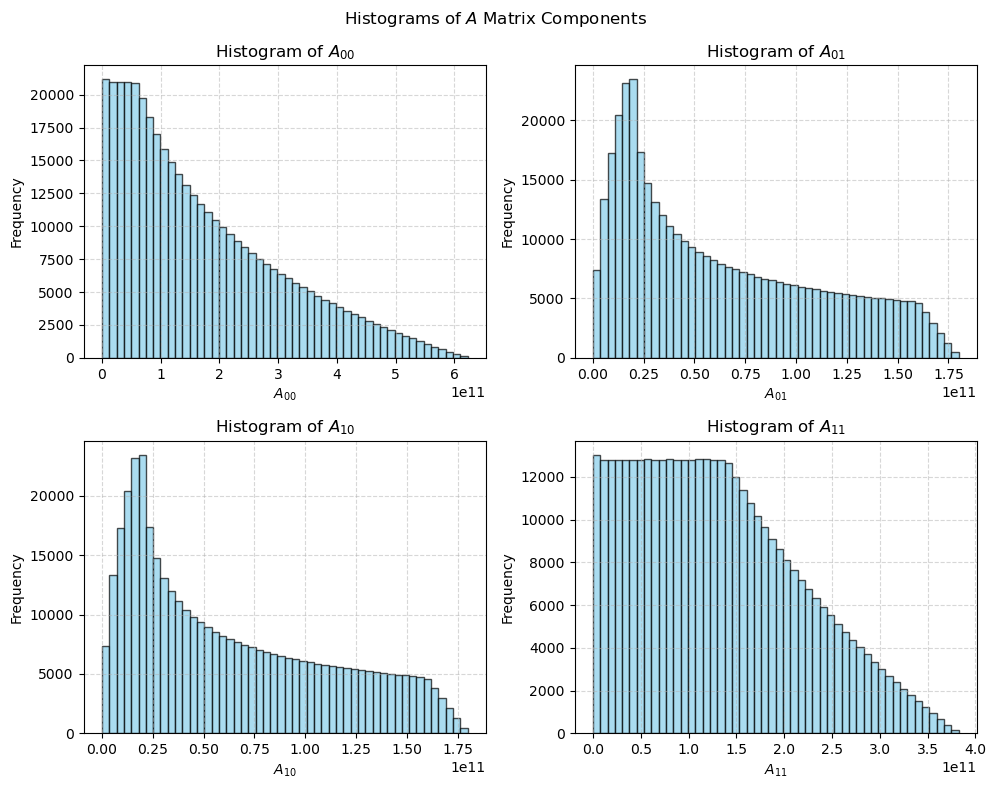

In [13]:
# Select columns related to matrix A
A_columns = [col for col in data.columns if col.startswith("$A_")]
data_A = data[A_columns]

# Define number of rows and columns for the subplot grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

# Plot histograms
for i, col in enumerate(A_columns):
    row, col_idx = divmod(i, 2)  # Compute subplot position
    ax = axes[row, col_idx]
    ax.hist(data_A[col], bins=50, color="skyblue", edgecolor="black", alpha=0.7)
    ax.set_title(f"Histogram of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.grid(True, linestyle="--", alpha=0.5)  # Add grid for better readability

# Adjust layout
plt.suptitle("Histograms of $A$ Matrix Components")
plt.tight_layout()
# uncomment/comment to save/ not to save
#plt.savefig("../images/single-yield/A_histograms.png", format="png", dpi = 300, bbox_inches="tight")
plt.show()

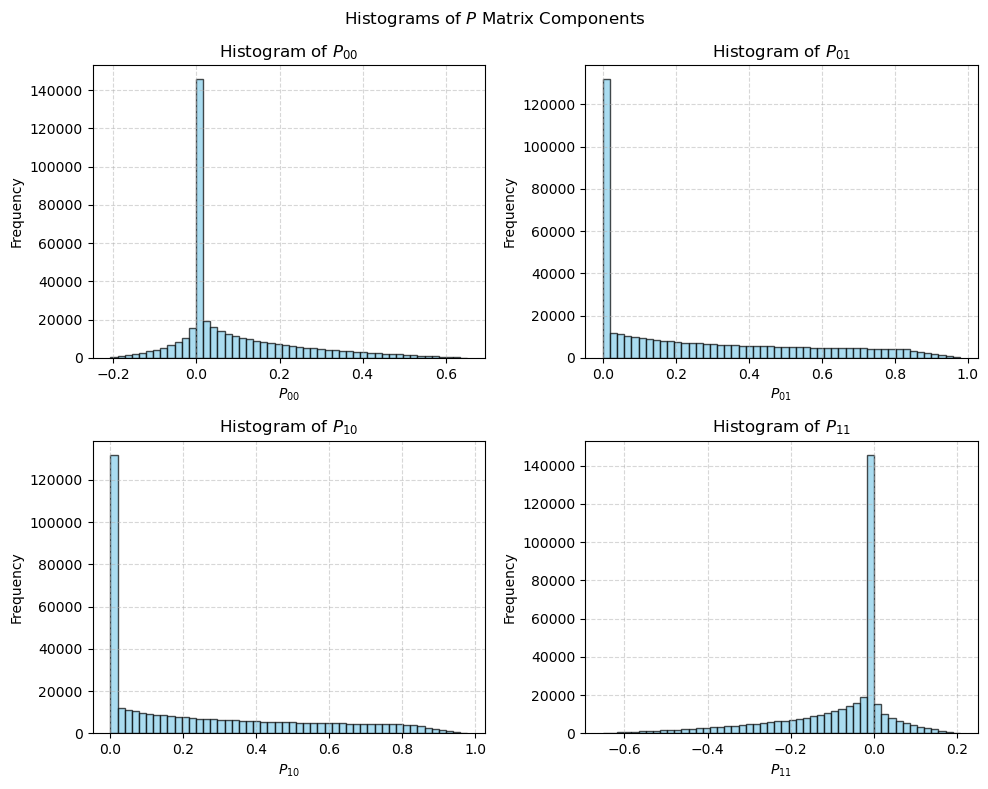

In [14]:
# Select columns related to matrix P
P_columns = [col for col in data.columns if col.startswith("$P_")]
data_P = data[P_columns]

# Define number of rows and columns for the subplot grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

# Plot histograms
for i, col in enumerate(P_columns):
    row, col_idx = divmod(i, 2)  # Compute subplot position
    ax = axes[row, col_idx]
    ax.hist(data_P[col], bins=50, color="skyblue", edgecolor="black", alpha=0.7)
    ax.set_title(f"Histogram of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.grid(True, linestyle="--", alpha=0.5)  # Add grid for better readability

# Adjust layout
plt.suptitle("Histograms of $P$ Matrix Components")
plt.tight_layout()
# uncomment/comment to save/ not to save
#plt.savefig("../images/single-yield/P_histograms.png", format="png", dpi = 300, bbox_inches="tight")
plt.show()

- As indicated in the text of the thesis and seen from the data statistics and visualization, the tensor A is symmetric and the tensor P is symmetric and has a zero trace. Therefore, for training I will leave only the data that bring new information

## Transform data

In [15]:
# delete A_10, P_10, P_11 column
data.drop(['$A_{10}$', '$P_{10}$', '$P_{11}$'], axis=1, inplace=True)

In [16]:
display(data.head())

,$A_{00}$,$A_{01}$,$A_{11}$,$P_{00}$,$P_{01}$
0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
1,6.729700e+07,1.979706e+05,1.562848e+08,-0.0,0.0
2,1.345940e+08,7.918822e+05,3.125695e+08,-0.0,0.0
3,2.018910e+08,1.781735e+06,4.688543e+08,-0.0,0.0
4,2.691880e+08,3.167529e+06,6.251390e+08,-0.0,0.0


In [17]:
# Apply log1p only to variables
log_data = np.log1p(data)

In [18]:
P_data = log_data[[col for col in log_data.columns if col.startswith("$P_")]]

In [19]:
A_data = log_data[[col for col in log_data.columns if col.startswith("$A_")]]

In [20]:
# Standard Normalisation
scaler_A = StandardScaler()
scaler_P = StandardScaler()

In [21]:
#A_normalized = scaler_A.fit_transform(A)
#P_normalized = scaler_P.fit_transform(P)
A_standardized = scaler_A.fit_transform(A_data)
P_standardized = scaler_P.fit_transform(P_data)

## Visualize after transformations

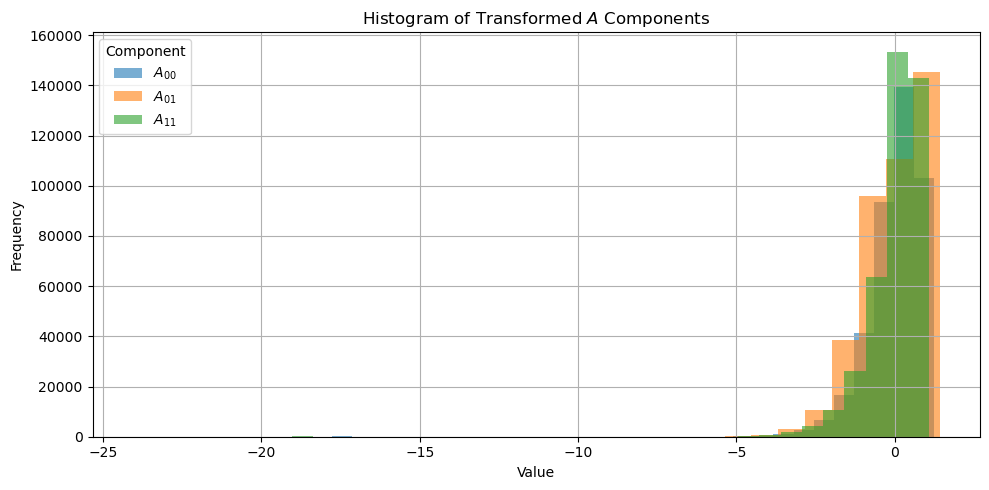

In [22]:
component_labels = ["A_{00}", "A_{01}", "A_{11}"]

plt.figure(figsize=(10, 5))
for i in range(A_standardized.shape[1]):
    plt.hist(A_standardized[:, i], bins=30, alpha=0.6, label=f"${component_labels[i]}$")

plt.title("Histogram of Transformed $A$ Components")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend(title="Component")
plt.grid(True)
plt.tight_layout()

# save
#plt.savefig("../images/single-yield/A_transform_histogram.png", format="png", dpi = 300, bbox_inches="tight")
plt.show()

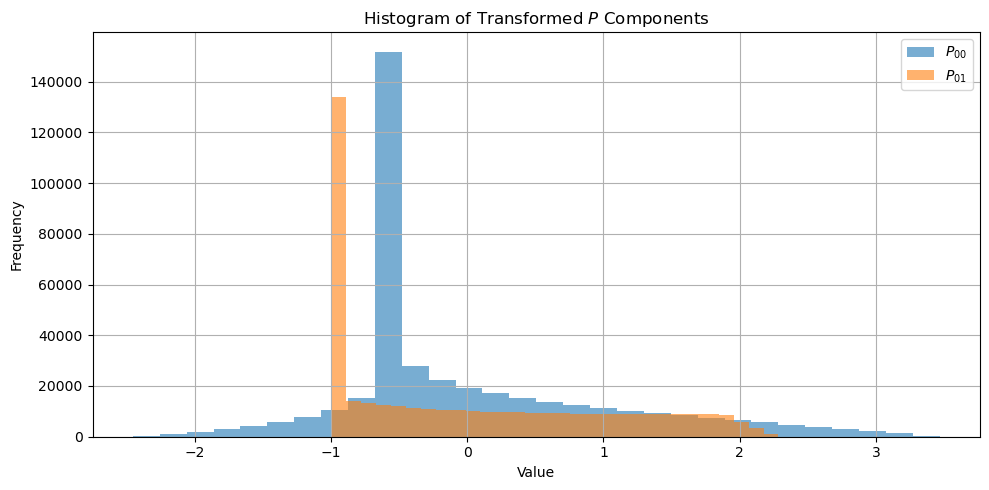

In [23]:
component_labels = ["P_{00}", "P_{01}"]

plt.figure(figsize=(10, 5))
for i in range(P_standardized.shape[1]):
    plt.hist(P_standardized[:, i], bins=30, alpha=0.6, label=f"${component_labels[i]}$")
plt.title("Histogram of Transformed $P$ Components")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
# uncomment/comment to save/ not to save
#plt.savefig("../images/single-yield/P_transform_histogram.png", format="png", dpi = 300, bbox_inches="tight")
plt.show()

## Create tensors for NN

In [14]:
# Save Scaler
joblib.dump(scaler_A, 'scaler_A.pkl')
joblib.dump(scaler_P, 'scaler_P.pkl')

['scaler_P.pkl']

In [15]:
X_train, X_val, y_train, y_val = train_test_split(A_standardized, P_standardized, test_size=0.2, random_state=42)

In [16]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32, device=device)

# Neural Network

In [17]:
class DynamicMLP(nn.Module):
    """
    Multilayer perceptron (MLP) with dynamic layer configuration and optional Dropout regularisation.

    This class allows the creation of MLPs with an arbitrary number of layers and neurons, and with the ability to
    adding Dropout between layers to prevent overtraining.

    Args:
        layers (list): A list containing the number of neurons in each layer. The length of the list determines
                       the number of layers; the list values are the number of neurons in each corresponding layer.
        dropout_rate (float, optional): The probability of neurons in Dropout layers being switched off.
                                        The default is 0, which means no Dropout.
    """
    def __init__(self, layers, dropout_rate=0):
        super(DynamicMLP, self).__init__()
        self.layers = nn.ModuleList()
        self.dropout_rate = dropout_rate

        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:  # no activation function after last layer
                self.layers.append(nn.ReLU())  # Reduced linear unit
                if self.dropout_rate != 0:
                    self.layers.append(nn.Dropout(self.dropout_rate))

    def forward(self, x):
        """
        Forward pass of the MLP model.

        This method propagates the input `x` through the network layers, applying
        linear transformations, ReLU activations (except for the last layer), and
        optional dropout regularization.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, output_dim).
        """
        x = x.flatten(start_dim=1)
        for layer in self.layers:
            x = layer(x)
        return x

In [18]:
# parameters
layer_configs = [
    [3, 256, 128, 2],                # 35k params
    [3, 512, 256, 128, 2],           # 168k
    [3, 256, 512, 256, 2],           # 265k
]
dropout_rates = [0, 0.1, 0.33]
optimizers = ['adam', 'sgd']
learning_rates = [1e-5, 1e-4, 1e-3]
weight_decays = [1e-5, 1e-4, 1e-3]
deltas =  [0.5, 1.0, 1.5]

In [19]:
# Combinations list
grid_full = list(itertools.product(layer_configs, dropout_rates, optimizers, learning_rates, weight_decays, deltas))

In [20]:
# --- random sub‑grid of size N ----------------------------------
N = 50                                   # how many configs you want
rnd = random.Random(42)                  # fixed seed = reproducible
grid = rnd.sample(grid_full, k=min(N, len(grid_full)))

In [21]:
# Early stopping function
class EarlyStopping:
    """
    Implements early stopping to halt training when validation loss stops improving.

    Attributes:
    - patience (int): Number of epochs to wait after the last improvement before stopping.
    - delta (float): Minimum change in the monitored value to qualify as an improvement.
    - best_loss (float or None): Tracks the best recorded validation loss.
    - counter (int): Counts the number of epochs since the last improvement.
    - early_stop (bool): Indicates whether training should be stopped.

    Methods:
    - __call__(val_loss): Updates the tracking variables and determines whether to stop training.
    """

    def __init__(self, patience=5, delta=0):
        """
        Initializes the early stopping mechanism.

        Args:
        - patience (int): Number of epochs to wait before stopping if no improvement is detected.
        - delta (float): Minimum required decrease in loss to reset the patience counter.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        """
        Checks whether validation loss has improved and updates internal state.

        Args:
        - val_loss (float): The current validation loss.

        If the validation loss has not improved for `patience` epochs, sets `early_stop` to True.
        """
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [22]:
class CombinedLoss(nn.Module):
    """
    Custom loss function combining Mean Absolute Error (MAE) and Mean Squared Error (MSE).

    This loss function balances between MAE and MSE using a weighting factor `alpha`.
    - MAE (L1 loss) is robust to outliers and encourages sparsity.
    - MSE (L2 loss) penalizes larger errors more heavily, making it sensitive to outliers.

    Args:
    - alpha (float, optional): Weighting factor between MAE and MSE.
      - `alpha = 1.0` results in pure MAE.
      - `alpha = 0.0` results in pure MSE.
      - Default is 0.5, giving equal weight to both losses.
    """

    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.mae = nn.L1Loss()
        self.mse = nn.MSELoss()

    def forward(self, outputs, targets):
        """
        Computes the combined MAE + MSE loss.

        Args:
        - outputs (Tensor): Model predictions.
        - targets (Tensor): Ground truth values.

        Returns:
        - Tensor: Weighted sum of MAE and MSE losses.
        """
        return self.alpha * self.mae(outputs, targets) + (1 - self.alpha) * self.mse(outputs, targets)


In [23]:
class PenalizedCombinedLoss(nn.Module):
    """
    Custom loss function that combines Mean Absolute Error (MAE) and
    Mean Squared Error (MSE) with an additional penalty for zero-plasticity regions.

    This loss function helps enforce better predictions in regions where the target
    value is expected to be zero by applying a penalty term.

    Args:
        alpha (float, optional): Weighting factor between MAE and MSE.
            - `alpha = 1.0` results in pure MAE.
            - `alpha = 0.0` results in pure MSE.
            - Default is 0.5.
        penalty_weight (float, optional): Weight of the penalty applied to
            predictions in regions where the target is zero (zero-plasticity regions).
            Higher values enforce stronger penalization.
            - Default is 1.
    """

    def __init__(self, alpha=0.5, penalty_weight=1):
        super(PenalizedCombinedLoss, self).__init__()
        self.alpha = alpha
        self.penalty_weight = penalty_weight
        self.mae = nn.L1Loss()
        self.mse = nn.MSELoss()

    def forward(self, outputs, targets):
        """
        Computes the combined loss function.

        The loss consists of:
        - A weighted combination of MAE and MSE.
        - An additional penalty term applied in regions where `targets == 0`.

        Args:
            outputs (torch.Tensor): Predicted values from the model.
            targets (torch.Tensor): Ground truth values.

        Returns:
            torch.Tensor: Computed loss value.
        """
        # Standard MAE + MSE loss
        loss = self.alpha * self.mae(outputs, targets) + (1 - self.alpha) * self.mse(outputs, targets)

        # Penalization term for zero-plasticity regions
        zero_mask = (targets == 0).float()  # Mask for zero-plasticity regions
        penalty = self.penalty_weight * torch.mean(zero_mask * torch.abs(outputs))

        # Total loss
        total_loss = loss + penalty
        return total_loss


In [24]:
class HuberLoss(nn.Module):
    def __init__(self, delta=0.5):
        """
        Standard Huber Loss.

        Args:
            delta (float): Threshold between quadratic and linear regions.
        """
        super().__init__()
        self.delta = delta

    def forward(self, pred, target):
        error = pred - target
        abs_error = torch.abs(error)

        loss = torch.where(
            abs_error < self.delta,
            0.5 * error ** 2,         # MSE region
            self.delta * (abs_error - 0.5 * self.delta)  # MAE region
        )

        return loss.mean()

In [29]:
def train_model(
    grid,
    model_class,
    loss_class,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    *,
    batch_size = 4096,
    epochs     = 100,
    patience   = 10,
    delta      = 1e-4,
):
    device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    use_amp  = device.type == "cuda"
    autocast = torch.cuda.amp.autocast if use_amp else contextlib.nullcontext

    # ---------- всё на нужный device ----------
    X_train_tensor = X_train_tensor.to(device)
    y_train_tensor = y_train_tensor.to(device)
    X_val_tensor   = X_val_tensor.to(device)
    y_val_tensor   = y_val_tensor.to(device)

    # ---------- DataLoaders ----------
    g = torch.Generator(device=device)  # чтобы randperm был на GPU
    g.manual_seed(42)                   # фиксим случайность

    train_dl = DataLoader(
        TensorDataset(X_train_tensor, y_train_tensor),
        batch_size  = batch_size,
        shuffle     = False,
        generator   = g,
        num_workers = 0,
        pin_memory  = False,   # уже на GPU
    )
    val_dl = DataLoader(
        TensorDataset(X_val_tensor, y_val_tensor),
        batch_size  = batch_size,
        shuffle     = False,
        num_workers = 0,
        pin_memory  = False,
    )

    best_state, best_cfg = None, None
    global_best_val      = float("inf")

    for layers, dropout, opt_name, lr, wd, delta_val in grid:
        print(f"\nCFG  layers={layers}  drop={dropout}  opt={opt_name}"
              f"  lr={lr}  wd={wd}  δ={delta_val}")

        model = model_class(layers, dropout_rate=dropout).to(device)
        criterion = loss_class(delta=delta_val).to(device)

        if opt_name == "adam":
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        else:
            optimizer = optim.SGD(model.parameters(), lr=lr,
                                  weight_decay=wd, momentum=0.9)

        scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

        best_val, strikes, local_best = float("inf"), 0, None

        # ------------- epochs -------------
        for epoch in range(epochs):
            model.train()
            for xb, yb in train_dl:
                optimizer.zero_grad(set_to_none=True)
                with autocast():
                    pred = model(xb)
                    loss = criterion(pred, yb)

                if use_amp:
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    optimizer.step()

            # -------- validation --------
            model.eval()
            val_acc = 0.0
            with torch.no_grad(), autocast():
                for xb, yb in val_dl:
                    val_acc += criterion(model(xb), yb).item() * xb.size(0)
            val_loss = val_acc / len(val_dl.dataset)

            if val_loss + delta < best_val:
                best_val   = val_loss
                local_best = model.state_dict()
                strikes    = 0
            else:
                strikes += 1
                if strikes >= patience:
                    print(f" early‑stop @ epoch {epoch}")
                    break

        if best_val < global_best_val:
            global_best_val = best_val
            best_state      = local_best
            best_cfg = {"layers": layers, "dropout": dropout,
                        "optimizer": opt_name, "lr": lr,
                        "weight_decay": wd, "delta": delta_val,
                        "val_loss": best_val}

        del model, optimizer, criterion, scaler, local_best
        if use_amp:
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
        gc.collect()

    return best_state, best_cfg, global_best_val

In [30]:
# Execute the training function
best_model_state, best_config, best_val_loss = train_model(
    grid=grid,
    model_class=DynamicMLP,
    loss_class=HuberLoss,
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_val_tensor=X_val_tensor,
    y_val_tensor=y_val_tensor,
    epochs=200,
    patience=10,
    delta=1e-3
)


CFG  layers=[3, 256, 512, 256, 2]  drop=0  opt=adam  lr=1e-05  wd=0.0001  δ=0.5


/tmp/ipykernel_5164/255076141.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipykernel_5164/255076141.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_5164/255076141.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


 early‑stop @ epoch 18

CFG  layers=[3, 256, 128, 2]  drop=0.1  opt=adam  lr=1e-05  wd=0.0001  δ=0.5
 early‑stop @ epoch 32

CFG  layers=[3, 256, 128, 2]  drop=0  opt=adam  lr=0.0001  wd=0.0001  δ=0.5
 early‑stop @ epoch 16

CFG  layers=[3, 256, 512, 256, 2]  drop=0.1  opt=adam  lr=1e-05  wd=1e-05  δ=1.0
 early‑stop @ epoch 21

CFG  layers=[3, 256, 128, 2]  drop=0.33  opt=sgd  lr=1e-05  wd=0.0001  δ=1.5

CFG  layers=[3, 256, 128, 2]  drop=0.33  opt=adam  lr=0.0001  wd=0.001  δ=1.5
 early‑stop @ epoch 17

CFG  layers=[3, 256, 128, 2]  drop=0.33  opt=adam  lr=1e-05  wd=0.001  δ=0.5
 early‑stop @ epoch 37

CFG  layers=[3, 256, 128, 2]  drop=0.1  opt=adam  lr=0.0001  wd=0.001  δ=1.5
 early‑stop @ epoch 12

CFG  layers=[3, 256, 512, 256, 2]  drop=0  opt=sgd  lr=0.001  wd=0.001  δ=1.5
 early‑stop @ epoch 33

CFG  layers=[3, 256, 128, 2]  drop=0  opt=sgd  lr=0.001  wd=0.001  δ=1.0
 early‑stop @ epoch 27

CFG  layers=[3, 256, 512, 256, 2]  drop=0  opt=adam  lr=0.001  wd=0.0001  δ=1.0
 early‑st

In [31]:
# Save the best model weights and configuration
file_name = "best_model_overall_bigger_data"
with open(f"{file_name}.pkl", "wb") as f:
    pickle.dump({"model_state": best_model_state, "config": best_config}, f)

print(f"Best model saved with val_loss: {best_val_loss:.4f}")
print("Best configuration:", best_config)

Best model saved with val_loss: 0.0001
Best configuration: {'layers': [3, 512, 256, 128, 2], 'dropout': 0, 'optimizer': 'adam', 'lr': 0.001, 'weight_decay': 0.0001, 'delta': 0.5, 'val_loss': 7.870974727426354e-05}
